## Resnet Features (1000)

This notebook develops csvs of resnet feature vectors for train, val, and test sets

In [139]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import urllib
import os
import cv2
import skimage
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
model = ResNet50(weights='imagenet')

In [70]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):
    # Check if the file path ends with ".jpg"
    if in_path.lower().endswith('.jpg'):
        img = cv2.imread(in_path, 0)

        # Histogram equalization
        img = np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
        img = cv2.equalizeHist(img)

        # Convert to floating-point image with intensity [0, 1]
        if np.max(img) > 1:
            img = img.astype(np.float32) / 255.0

        standard = 150
        scale = standard / min(img.shape[:2])
        img = rescale(img, scale, anti_aliasing=False)
        img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
                  int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]

        img = skimage.img_as_ubyte(img)

        return img

In [127]:
def extract_resnet_features(img_path):
    img = read_image(img_path)
    img = cv2.resize(img, (224, 224))
    img_array = image.img_to_array(img)
    
    # Repeat channels without adding an empty channel
    img_array = np.repeat(img_array, 3, axis=-1)

    # Apply preprocessing before expanding dimensions and repeating channels
    img_array = preprocess_input(img_array)
    # Add a batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Get the features from the specified layer
    features = model.predict(img_array)

    return features.flatten()

def expand_resnet_features(row):
    return pd.Series(row['resnet'], index=[f'res_{i+1}' for i in range(len(row['resnet']))])

def build_resnet_df(dataframe):
    # Apply the function to each row in the DataFrame
    resnet_features_df = pd.DataFrame(dataframe['files'].apply(extract_resnet_features)).rename({'files':'resnet'}, axis=1)

    # Concatenate the original DataFrame with the new ResNet features DataFrame
    result_df = pd.concat([dataframe, resnet_features_df], axis=1)
    
    expanded_resnet_df = pd.concat([result_df, result_df.apply(expand_resnet_features, axis=1)], axis=1)
    expanded_resnet_df = expanded_resnet_df.drop('resnet', axis=1)
    
    return expanded_resnet_df
    
    

In [149]:
df_train = pd.read_csv('train_data.csv', index_col=0)
df_val = pd.read_csv('val_data.csv', index_col=0)
df_test = pd.read_csv('test_data.csv', index_col=0)

In [135]:
# train_resnet=build_resnet_df(df_train)
# val_resnet=build_resnet_df(df_val)
# test_resnet=build_resnet_df(df_test)

In [130]:
val_resnet

,files,labels,train_or_val,res_1,res_2,res_3,res_4,res_5,res_6,res_7,...,res_991,res_992,res_993,res_994,res_995,res_996,res_997,res_998,res_999,res_1000
0,./seg_train/seg_train/buildings/10006.jpg,building,validation,1.392475e-06,7.873412e-07,1.731329e-06,6.909756e-07,4.368831e-07,7.994053e-07,2.529221e-07,...,9.001676e-06,6.068750e-07,1.432506e-06,1.173351e-06,1.254524e-06,1.567508e-05,7.538531e-06,6.790710e-07,2.281866e-05,3.407939e-06
1,./seg_train/seg_train/buildings/10029.jpg,building,validation,5.867939e-07,4.175306e-07,1.406381e-07,4.051074e-07,8.549277e-08,3.998135e-07,2.197815e-08,...,1.833552e-06,8.427673e-08,1.042106e-07,3.145591e-07,9.750902e-07,1.033166e-05,1.578540e-06,1.374476e-07,1.125658e-05,3.664550e-06
2,./seg_train/seg_train/buildings/10032.jpg,building,validation,1.453289e-07,1.164680e-06,1.899605e-06,1.246938e-05,1.796314e-06,1.265234e-06,1.052043e-06,...,1.045004e-04,8.341759e-07,9.723891e-07,6.783141e-07,1.119454e-06,1.707232e-05,1.800942e-06,3.846913e-07,1.511222e-05,8.778276e-06
3,./seg_train/seg_train/buildings/1009.jpg,building,validation,7.402749e-07,3.902775e-07,3.167172e-07,6.931497e-08,7.555813e-07,1.013906e-07,9.564089e-08,...,1.965238e-06,1.613872e-07,2.311923e-07,3.758608e-08,1.809683e-08,3.996203e-07,3.083824e-07,7.578512e-08,5.168336e-07,2.630396e-06
4,./seg_train/seg_train/buildings/10113.jpg,building,validation,2.531459e-07,1.821438e-07,2.119140e-06,1.957952e-06,5.334917e-07,7.248646e-07,7.888034e-08,...,1.141241e-05,3.307924e-08,2.677678e-07,4.151487e-07,5.803500e-08,1.340729e-06,4.832217e-06,1.474660e-07,1.819461e-05,5.383812e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,./seg_train/seg_train/street/970.jpg,street,validation,2.369244e-08,4.176787e-07,2.554173e-07,6.961799e-07,1.414595e-06,4.435891e-07,8.457010e-08,...,2.824613e-06,3.739078e-08,2.802535e-08,2.805858e-07,1.291189e-07,2.603809e-06,5.710235e-06,6.055399e-08,1.726549e-06,2.135338e-06
2800,./seg_train/seg_train/street/9863.jpg,street,validation,1.692289e-08,2.254281e-08,7.888661e-07,1.083833e-06,1.338930e-06,4.795120e-07,1.231387e-06,...,1.560762e-07,6.488754e-08,2.617117e-08,3.064737e-08,1.404459e-08,1.370940e-07,8.790028e-07,5.572631e-09,2.173822e-07,1.411826e-06
2801,./seg_train/seg_train/street/9872.jpg,street,validation,4.426029e-10,1.095678e-09,6.701124e-09,4.175244e-09,2.488278e-09,4.198610e-09,3.944220e-10,...,1.853520e-09,1.001448e-10,2.611364e-10,1.447335e-10,1.261259e-10,2.068548e-09,2.530448e-09,3.719924e-10,1.514622e-08,1.951925e-08
2802,./seg_train/seg_train/street/994.jpg,street,validation,4.808866e-07,8.114229e-07,2.425719e-06,1.013888e-05,2.999587e-05,5.487664e-06,1.213208e-06,...,5.588555e-06,4.865727e-07,3.688436e-07,6.039681e-07,3.205513e-07,7.228249e-07,1.044496e-05,4.512628e-07,2.450918e-05,4.011445e-05


In [151]:
df_train = pd.read_csv('train_resnet.csv', index_col=0)

In [152]:
df_train

,files,labels,train_or_val,res_1,res_2,res_3,res_4,res_5,res_6,res_7,...,res_991,res_992,res_993,res_994,res_995,res_996,res_997,res_998,res_999,res_1000
0,./seg_train/seg_train/buildings/0.jpg,building,training,6.654819e-06,1.526390e-07,7.366177e-06,1.076602e-05,1.893316e-06,1.191438e-06,4.334958e-07,...,4.167721e-06,2.158211e-06,5.904865e-07,1.288369e-06,9.919127e-07,1.897755e-05,2.790817e-05,4.818478e-07,8.228128e-06,8.343523e-07
1,./seg_train/seg_train/buildings/1001.jpg,building,training,4.836220e-08,3.873964e-08,2.382573e-06,1.261549e-06,6.436675e-07,9.919793e-07,2.287443e-07,...,1.696466e-06,2.202982e-08,1.420953e-08,6.721601e-08,3.885782e-08,1.968007e-07,1.188279e-06,1.973723e-08,6.154577e-07,4.719319e-07
2,./seg_train/seg_train/buildings/10014.jpg,building,training,6.009966e-07,4.450627e-07,5.643459e-06,2.439136e-07,9.908920e-07,1.541075e-07,2.154505e-07,...,9.414865e-07,3.305464e-07,1.655347e-07,2.085787e-08,6.880236e-07,5.563913e-06,1.200556e-05,6.165252e-07,2.910279e-05,1.475344e-06
3,./seg_train/seg_train/buildings/10018.jpg,building,training,5.791483e-07,1.001774e-07,6.207035e-05,1.493675e-04,8.488697e-07,4.718170e-05,5.239130e-05,...,2.472801e-07,2.811269e-07,7.010432e-06,4.059911e-07,3.939365e-06,2.139476e-07,2.440305e-05,6.369614e-08,3.868958e-05,3.412553e-05
4,./seg_train/seg_train/buildings/10056.jpg,building,training,3.564252e-07,6.187923e-07,2.872177e-06,3.996673e-06,1.287826e-06,2.384596e-06,5.881290e-07,...,1.937030e-05,2.277373e-07,3.255058e-07,5.757029e-07,2.479512e-07,8.827865e-06,6.563723e-06,3.589234e-07,5.496050e-06,7.935602e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11225,./seg_train/seg_train/street/9961.jpg,street,training,3.343361e-09,1.153359e-07,8.539070e-07,8.849052e-08,3.509186e-07,2.450230e-07,1.461124e-07,...,3.049854e-07,3.408622e-08,4.742849e-08,1.291979e-08,8.172754e-09,9.027973e-08,1.513575e-07,6.028188e-09,2.398987e-07,1.114251e-05
11226,./seg_train/seg_train/street/9967.jpg,street,training,4.629114e-08,1.490572e-06,1.613119e-06,4.355129e-06,5.914982e-06,1.187632e-06,4.339513e-07,...,1.468134e-05,1.034074e-07,4.709046e-07,2.815165e-07,1.732398e-07,6.408250e-07,1.575049e-06,4.785612e-07,2.263041e-06,2.001328e-05
11227,./seg_train/seg_train/street/9978.jpg,street,training,6.229926e-08,1.770381e-07,5.198187e-07,5.650899e-07,4.033254e-07,2.322101e-07,8.603769e-08,...,7.979185e-06,1.705717e-07,1.015922e-07,1.987016e-07,1.336363e-07,1.950262e-06,2.305997e-06,6.132869e-07,4.025839e-06,1.283420e-06
11228,./seg_train/seg_train/street/9989.jpg,street,training,1.792289e-06,9.852946e-06,1.102024e-04,3.954092e-05,3.484758e-05,1.223428e-05,1.154506e-05,...,3.848870e-06,1.015433e-06,1.296526e-06,2.150651e-07,9.517808e-08,1.644347e-06,6.077453e-06,2.161652e-07,9.620188e-06,7.596226e-05


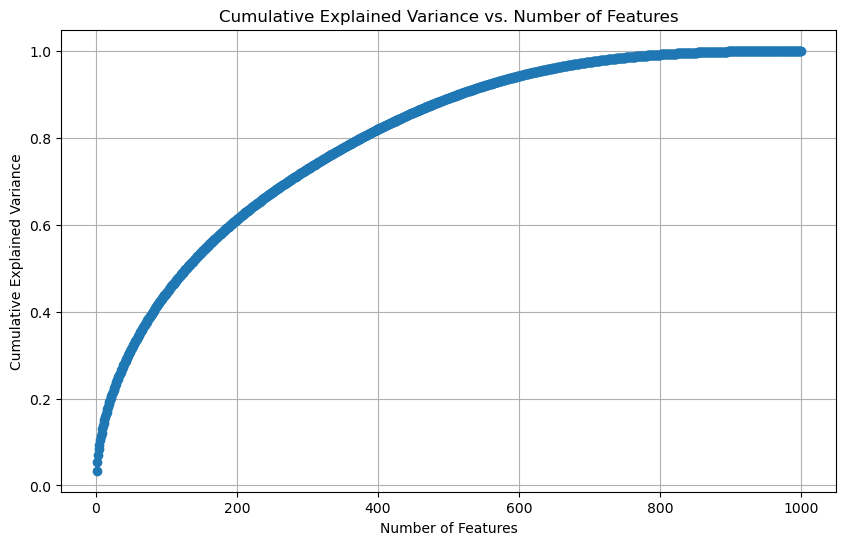

In [153]:
# Drop specified columns
columns_to_drop = ['files', 'labels', 'train_or_val']
df_train = df_train.drop(columns=columns_to_drop)

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_train_standardized = scaler.fit_transform(df_train)

# Apply PCA
pca = PCA()
pca.fit(df_train_standardized)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variation versus the number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [136]:
# train_resnet.to_csv('train_resnet.csv')
# val_resnet.to_csv('val_resnet.csv')
# test_resnet.to_csv('test_resnet.csv')